<a href="https://colab.research.google.com/github/antoniog18/BME-4790-Projects/blob/main/UNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import h5py
import numpy as np

## LOAD H5 SLICES

def load_h5_slice(filepath):
    with h5py.File(filepath, 'r') as f:
        image = f['image'][:]   # shape: (H, W, 4)
        mask  = f['mask'][:]    # shape: (H, W)
    return image, mask

# normalize image - do nothing with the mask

def preprocess_image(image):
    # Z-score normalization across channels
    return (image - image.mean()) / (image.std() + 1e-8)

# preprocessing for one subject

def preprocess_subject(h5_dir, subject_id, save_dir="./preprocessed"):

    os.makedirs(save_dir, exist_ok=True)

    X_list = []  # images
    Y_list = []  # masks

    # Find all slices for this subject

    slice_files = sorted([
        f for f in os.listdir(h5_dir)
        if f.startswith(f"volume_{subject_id}_")
    ])

    print(f"Found {len(slice_files)} slices for subject {subject_id}.")

    # Process each .h5 slice
    for fname in slice_files:
        path = os.path.join(h5_dir, fname)
        image, mask = load_h5_slice(path)

        # Normalize image
        image = preprocess_image(image)

        X_list.append(image)
        Y_list.append(mask)

    # Convert to arrays
    X = np.array(X_list)    # shape: (num_slices, H, W, 4)
    Y = np.array(Y_list)    # shape: (num_slices, H, W)

    # Save Numpy versions
    np.save(os.path.join(save_dir, f"volume_{subject_id}_X.npy"), X)
    np.save(os.path.join(save_dir, f"volume_{subject_id}_Y.npy"), Y)

    print(f"✓ Saved preprocessed arrays for subject {subject_id}.")

# ---------------------------------------------------
# Example usage (update the path!)
# ---------------------------------------------------

h5_dir = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data"    # adjust if needed
subject_id = 200              # Volume 200 recommended
preprocess_subject(h5_dir, subject_id)


Found 155 slices for subject 200.
✓ Saved preprocessed arrays for subject 200.


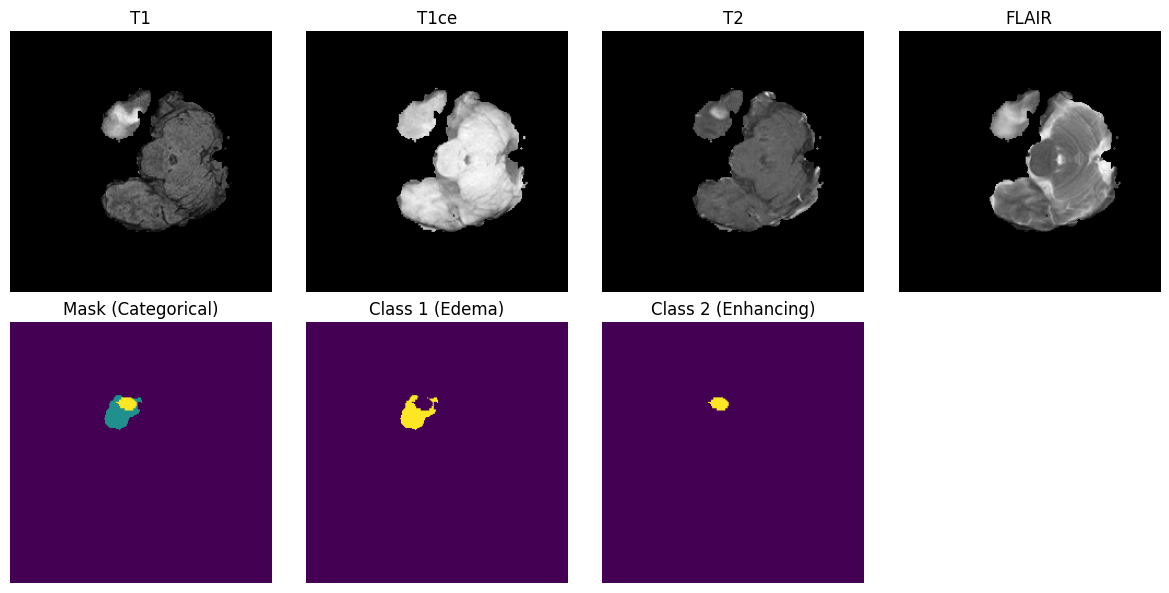

In [ ]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# pick one slice file
fp = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data/volume_200_slice_38.h5"


with h5py.File(fp, 'r') as f:
    img = f['image'][:]      # (240,240,4)
    mask = f['mask'][:]      # (240,240,3)

mask_int = np.argmax(mask, axis=-1)

plt.figure(figsize=(12,6))

# MRI modalities
mods = ["T1", "T1ce", "T2", "FLAIR"]
for i in range(4):
    plt.subplot(2,4,i+1)
    plt.imshow(img[:,:,i], cmap='gray')
    plt.title(mods[i])
    plt.axis('off')

# Mask
plt.subplot(2,4,5)
plt.imshow(mask_int)
plt.title("Mask (Categorical)")
plt.axis('off')

# Legend-like colors
plt.subplot(2,4,6)
plt.imshow(mask[:,:,1]) # class 1 channel
plt.title("Class 1 (Edema)")
plt.axis('off')

plt.subplot(2,4,7)
plt.imshow(mask[:,:,2])
plt.title("Class 2 (Enhancing)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
import h5py

file_path = "/content/drive/MyDrive/BME-AIML-Final-Project/archive/BraTS2020_training_data/content/data/volume_200_slice_38.h5"
with h5py.File(file_path, 'r') as f:
    print("Keys:", list(f.keys()))
    print("Image shape:", f['image'].shape)
    print("Mask shape:", f['mask'].shape)
    print("Image min/max:", f['image'][:].min(), f['image'][:].max())
    print("Mask unique values:", np.unique(f['mask'][:]))


Keys: ['image', 'mask']
Image shape: (240, 240, 4)
Mask shape: (240, 240, 3)
Image min/max: -0.458984498864448 6.9094707753545865
Mask unique values: [0 1]


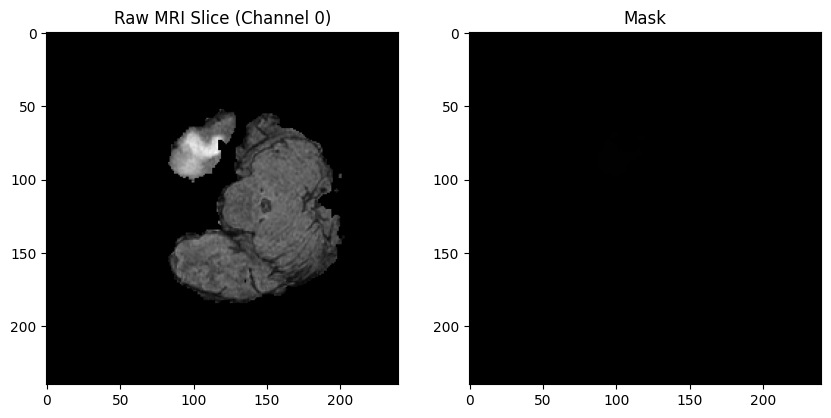

In [ ]:
with h5py.File(file_path, 'r') as f:
    image = f['image'][:]       # raw image
    mask  = f['mask'][:]

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(image[:,:,0], cmap='gray')  # T1
plt.title("Raw MRI Slice (Channel 0)")

plt.subplot(1,2,2)
plt.imshow(mask)
plt.title("Mask")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cpu')

In [ ]:
X = np.load("/content/preprocessed/volume_200_X.npy")
Y = np.load("/content/preprocessed/volume_200_Y.npy")
print(X.shape, Y.shape)



(155, 240, 240, 4) (155, 240, 240, 3)


In [ ]:
Y_class = np.argmax(Y, axis=-1).astype(np.int64)
print(Y_class.shape)


(155, 240, 240)


In [ ]:
tumor_slices = [
    i for i in range(len(Y_class))
    if np.count_nonzero(Y_class[i]) > 50
]


In [ ]:
print("Tumor slices found:", len(tumor_slices))
print("Indices:", tumor_slices[:15])


Tumor slices found: 51
Indices: [82, 83, 84, 85, 86, 87, 88, 90, 91, 92, 93, 94, 95, 96, 97]


In [ ]:
X_clean = X[tumor_slices]
Y_clean = Y_class[tumor_slices]

print("X_clean:", X_clean.shape)
print("Y_clean:", Y_clean.shape)


X_clean: (51, 240, 240, 4)
Y_clean: (51, 240, 240)


In [ ]:
Y_class = np.argmax(Y, axis=-1).astype(np.int64)

tumor_slices = [
    i for i in range(len(Y_class))
    if np.count_nonzero(Y_class[i]) > 50
]

X_clean = X[tumor_slices]
Y_clean = Y_class[tumor_slices]


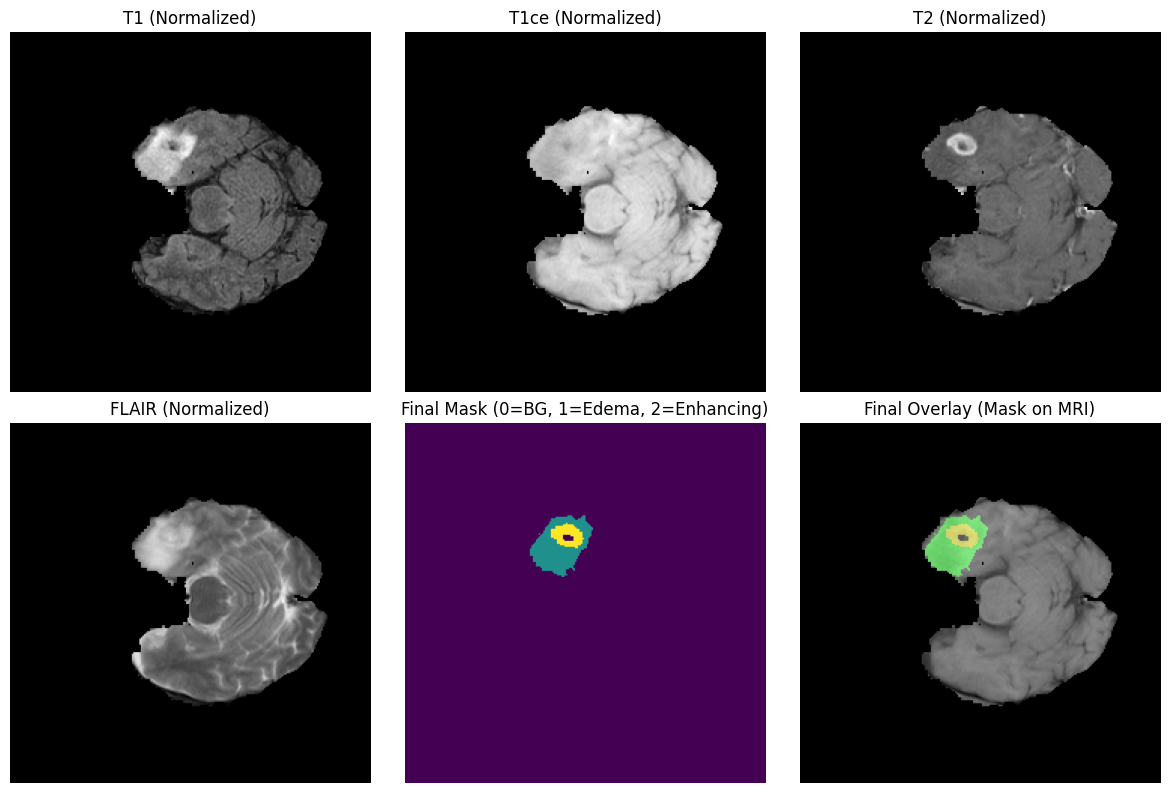

In [ ]:
import matplotlib.pyplot as plt

# Pick one tumor slice AFTER filtering
idx = tumor_slices[10]  # any index from your filtered list

img_after = X_clean[10]        # (240,240,4)
mask_after = Y_clean[10]       # (240,240)

mods = ["T1", "T1ce", "T2", "FLAIR"]

plt.figure(figsize=(12,8))

# ---- MRI MODALITIES ----
for i in range(4):
    plt.subplot(2,3,i+1)
    plt.imshow(img_after[:,:,i], cmap='gray')
    plt.title(f"{mods[i]} (Normalized)")
    plt.axis('off')

# ---- FINAL MASK ----
plt.subplot(2,3,5)
plt.imshow(mask_after, cmap='viridis')
plt.title("Final Mask (0=BG, 1=Edema, 2=Enhancing)")
plt.axis('off')

# ---- OVERLAY ----
# color map (green = class 1, yellow = class 2)
import numpy as np
overlay = np.zeros((240,240,3))
overlay[mask_after == 1] = [0,1,0]
overlay[mask_after == 2] = [1,1,0]

plt.subplot(2,3,6)
plt.imshow(img_after[:,:,1], cmap='gray')
plt.imshow(overlay, alpha=0.4)
plt.title("Final Overlay (Mask on MRI)")
plt.axis('off')

plt.tight_layout()
plt.show()


In [ ]:
class BrainTumorDataset(torch.utils.data.Dataset):
    def __init__(self, images, masks):
        self.images = images
        self.masks = masks

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img = self.images[idx]
        mask = self.masks[idx]

        img_t  = torch.tensor(img, dtype=torch.float32).permute(2,0,1)
        mask_t = torch.tensor(mask, dtype=torch.long)

        return img_t, mask_t


In [ ]:
dataset = BrainTumorDataset(X_clean, Y_clean)

n = len(dataset)
n_train = int(0.8*n)

train_set, val_set = torch.utils.data.random_split(dataset, [n_train, n-n_train])

train_loader = DataLoader(train_set, batch_size=1, shuffle=True)
val_loader   = DataLoader(val_set, batch_size=1, shuffle=False)


In [ ]:


class UNet(nn.Module):
    def __init__(self, num_classes=3):
        super().__init__()

        self.down1 = DoubleConv(4, 16)      # input channels = 4
        self.pool1 = nn.MaxPool2d(2)

        self.down2 = DoubleConv(16, 32)
        self.pool2 = nn.MaxPool2d(2)

        self.down3 = DoubleConv(32, 64)
        self.pool3 = nn.MaxPool2d(2)

        self.bottleneck = DoubleConv(64, 128)

        self.up3 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv3 = DoubleConv(128, 64)

        self.up2 = nn.ConvTranspose2d(64, 32, 2, stride=2)
        self.conv2 = DoubleConv(64, 32)

        self.up1 = nn.ConvTranspose2d(32, 16, 2, stride=2)
        self.conv1 = DoubleConv(32, 16)

        self.out = nn.Conv2d(16, num_classes, 1)

    def forward(self, x):
        c1 = self.down1(x)
        p1 = self.pool1(c1)

        c2 = self.down2(p1)
        p2 = self.pool2(c2)

        c3 = self.down3(p2)
        p3 = self.pool3(c3)

        bn = self.bottleneck(p3)

        u3 = self.up3(bn)
        merge3 = torch.cat([u3, c3], dim=1)
        c4 = self.conv3(merge3)

        u2 = self.up2(c4)
        merge2 = torch.cat([u2, c2], dim=1)
        c5 = self.conv2(merge2)

        u1 = self.up1(c5)
        merge1 = torch.cat([u1, c1], dim=1)
        c6 = self.conv1(merge1)

        return self.out(c6)


In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

for epoch in range(10):
    model.train()
    train_loss = 0

    for img, mask in train_loader:
        img = img.to(device)
        mask = mask.to(device)

        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    print(f"Epoch {epoch+1}, train loss = {train_loss/len(train_loader):.4f}")


Epoch 1, train loss = 0.0113
Epoch 2, train loss = 0.0103
Epoch 3, train loss = 0.0098
Epoch 4, train loss = 0.0096
Epoch 5, train loss = 0.0092
Epoch 6, train loss = 0.0088
Epoch 7, train loss = 0.0087
Epoch 8, train loss = 0.0082
Epoch 9, train loss = 0.0079
Epoch 10, train loss = 0.0077


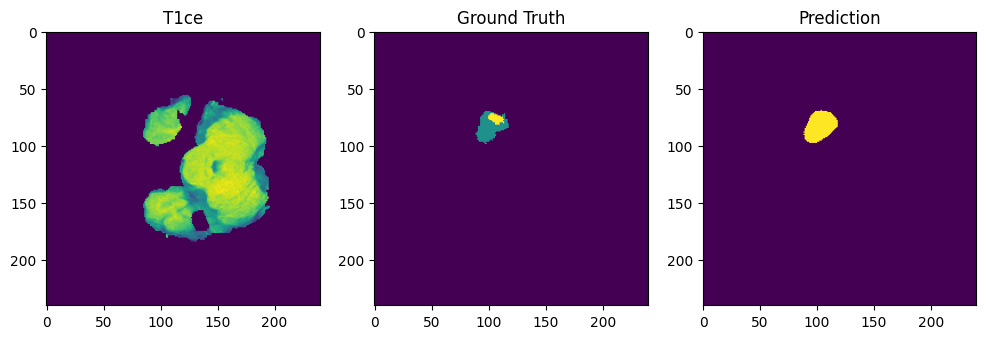

In [ ]:
model.eval()
img, mask = dataset[3]
with torch.no_grad():
    pred = model(img.unsqueeze(0).to(device))
pred_mask = torch.argmax(pred, dim=1)[0].cpu().numpy()

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(img.permute(1,2,0)[:,:,1]); plt.title("T1ce")
plt.subplot(1,3,2); plt.imshow(mask); plt.title("Ground Truth")
plt.subplot(1,3,3); plt.imshow(pred_mask); plt.title("Prediction")
plt.show()



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch

def overlay_mask_on_mri(mri, mask, alpha=0.35):
    """
    mri : numpy array (240,240), any intensity range
    mask: numpy array (240,240) with values {0,1,2}
    alpha: transparency of mask overlay
    """

    # 1. Normalize MRI to [0,1] for display
    mri = (mri - mri.min()) / (mri.max() - mri.min() + 1e-8)
    mri_rgb = np.stack([mri, mri, mri], axis=-1)

    # 2. Define colors for each tumor class (in [0,1] RGB)
    colors = {
        1: np.array([0.0, 1.0, 0.0]),   # green for class 1
        2: np.array([1.0, 1.0, 0.0]),   # yellow for class 2
    }

    # 3. Create empty color overlay
    overlay = np.zeros_like(mri_rgb)

    # 4. Paint each class
    for cls, color in colors.items():
        overlay[mask == cls] = color

    # 5. Alpha blend
    combined = (1 - alpha) * mri_rgb + alpha * overlay

    return np.clip(combined, 0, 1)


def visualize_mri_gt_pred(dataset, model, index, modality=1):
    img, gt_mask = dataset[index]

    # Convert tensor to numpy
    img_np = img.permute(1,2,0).numpy()  # (240,240,4)
    mri_slice = img_np[:,:,modality]

    # Predict
    model.eval()
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))
    pred_mask = torch.argmax(pred, dim=1)[0].cpu().numpy()

    # Overlays
    overlay_gt   = overlay_mask_on_mri(mri_slice, gt_mask)
    overlay_pred = overlay_mask_on_mri(mri_slice, pred_mask)

    plt.figure(figsize=(16,5))

    plt.subplot(1,3,1)
    plt.imshow(mri_slice, cmap='gray')
    plt.title("MRI Slice (T1ce)")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(overlay_gt)
    plt.title("Ground Truth Overlay")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.imshow(overlay_pred)
    plt.title("Predicted Mask Overlay")
    plt.axis('off')

    plt.tight_layout()
    plt.show()


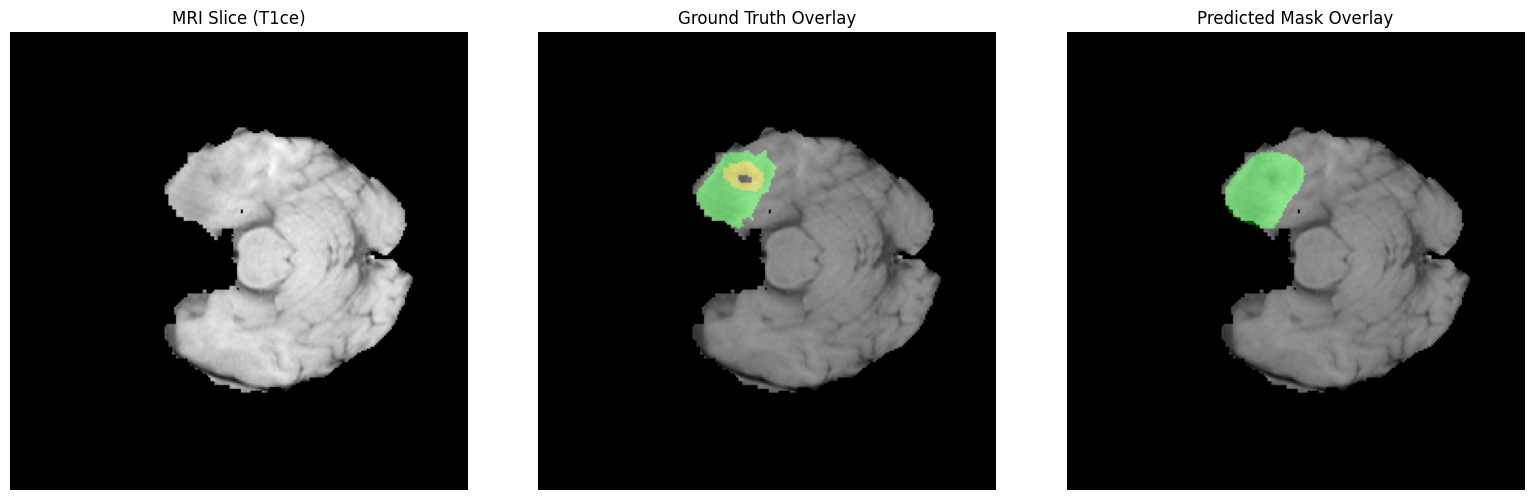

In [ ]:
visualize_mri_gt_pred(dataset, model, index=10, modality=1)


In [ ]:
# ============================================================
# FINAL AUTOENCODER BLOCK — FULL PIPELINE
# ============================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ============================================================
# STEP 1 — Ensure Y_clean is (N,240,240) integer masks
#         This fixes ALL mask shape issues.
# ============================================================

def fix_mask_shape(Y):
    """
    Takes Y in any of these shapes:
    - (N,240,240,3)
    - (N,1,240,240,3)
    - (N,240,240)
    And returns: (N,240,240) with integer labels {0,1,2}
    """

    Y = np.array(Y)

    # Case 1: already correct (N,240,240)
    if Y.ndim == 3:
        return Y.astype(np.int64)

    # Case 2: (N,240,240,3) = one-hot
    if Y.ndim == 4 and Y.shape[-1] == 3:
        return np.argmax(Y, axis=-1).astype(np.int64)

    # Case 3: (N,1,240,240,3) — squeeze extra dim
    if Y.ndim == 5:
        Y = np.squeeze(Y, axis=1)
        if Y.shape[-1] == 3:
            return np.argmax(Y, axis=-1).astype(np.int64)

    raise ValueError(f"Unexpected Y shape: {Y.shape}")

# Fix Y_clean
Y_clean = fix_mask_shape(Y_clean)
print("Fixed Y_clean shape:", Y_clean.shape)   # should be (N,240,240)


# ============================================================
# STEP 2 — One-Hot Conversion (Robust)
# ============================================================

def mask_to_onehot(mask, num_classes=3):
    """
    mask: np array, shape (240,240), integer labels
    return: tensor (3,240,240)
    """
    # ensure int64
    mask = mask.astype(np.int64)

    # convert to torch long tensor
    mask_t = torch.tensor(mask, dtype=torch.long)

    # one-hot encode: (H,W,3)
    onehot = F.one_hot(mask_t, num_classes)

    # reorder to (3,H,W)
    return onehot.permute(2,0,1).float()


# ============================================================
# STEP 3 — Autoencoder Model
# ============================================================

class MaskAutoencoder(nn.Module):
    def __init__(self, latent_dim=64):
        super().__init__()

        # Encoder
        self.enc = nn.Sequential(
            nn.Conv2d(3, 16, 3, stride=2, padding=1),  # (3,240,240) → (16,120,120)
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1), # → (32,60,60)
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1), # → (64,30,30)
            nn.ReLU(),
            nn.Flatten(),
        )

        self.fc_enc = nn.Linear(64*30*30, latent_dim)

        # Decoder
        self.fc_dec = nn.Linear(latent_dim, 64*30*30)

        self.dec = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 2, stride=2),  # → (32,60,60)
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 2, stride=2),  # → (16,120,120)
            nn.ReLU(),
            nn.ConvTranspose2d(16, 3, 2, stride=2),   # → (3,240,240)
            nn.Sigmoid()
        )

    def forward(self, x):
        z = self.fc_enc(self.enc(x))       # latent vector
        x_hat = self.fc_dec(z)
        x_hat = x_hat.view(-1, 64, 30, 30)
        x_hat = self.dec(x_hat)
        return x_hat, z


# ============================================================
# STEP 4 — Train the Autoencoder
# ============================================================

ae = MaskAutoencoder(latent_dim=64).to(device)
ae_optimizer = torch.optim.Adam(ae.parameters(), lr=1e-4)
ae_loss_fn = nn.MSELoss()

epochs = 20

print("\nStarting AE Training...\n")
for epoch in range(epochs):
    ae.train()
    total_loss = 0

    for y in Y_clean:
        y_oh = mask_to_onehot(y).unsqueeze(0).to(device)  # (1,3,240,240)

        ae_optimizer.zero_grad()
        y_hat, z = ae(y_oh)
        loss = ae_loss_fn(y_hat, y_oh)
        loss.backward()
        ae_optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | AE Loss = {total_loss/len(Y_clean):.4f}")


# ============================================================
# STEP 5 — Extract Latent Vectors
# ============================================================

ae.eval()
latents = []

for y in Y_clean:
    y_oh = mask_to_onehot(y).unsqueeze(0).to(device)
    with torch.no_grad():
        _, z = ae(y_oh)
    latents.append(z.cpu().numpy())

latents = np.vstack(latents)
print("\nLatent vectors shape:", latents.shape)   # (N, 64)


# ============================================================
# STEP 6 — Visualize AE Reconstruction
# ============================================================

def visualize_ae_reconstruction(index):
    y = Y_clean[index]
    y_oh = mask_to_onehot(y).unsqueeze(0).to(device)

    ae.eval()
    with torch.no_grad():
        y_hat, z = ae(y_oh)

    y_hat = y_hat[0].cpu().numpy()        # (3,240,240)
    y_hat_mask = np.argmax(y_hat, axis=0) # predicted mask

    plt.figure(figsize=(12,4))
    plt.subplot(1,3,1)
    plt.imshow(y)
    plt.title("Original Mask")
    plt.axis('off')

    plt.subplot(1,3,2)
    plt.imshow(y_hat_mask)
    plt.title("AE Reconstruction")
    plt.axis('off')

    plt.subplot(1,3,3)
    plt.plot(z.cpu().numpy().ravel())
    plt.title("Latent Vector (64-D)")
    plt.show()


print("\nTo visualize AE reconstruction, call:")
print("visualize_ae_reconstruction(10)")


Using device: cpu
Fixed Y_clean shape: (51, 240, 240)

Starting AE Training...

Epoch 1/20 | AE Loss = 0.2609
Epoch 2/20 | AE Loss = 0.1715
Epoch 3/20 | AE Loss = 0.0847
Epoch 4/20 | AE Loss = 0.0563
Epoch 5/20 | AE Loss = 0.0345
Epoch 6/20 | AE Loss = 0.0264
Epoch 7/20 | AE Loss = 0.0257
Epoch 8/20 | AE Loss = 0.0221
Epoch 9/20 | AE Loss = 0.0067
Epoch 10/20 | AE Loss = 0.0055
Epoch 11/20 | AE Loss = 0.0053
Epoch 12/20 | AE Loss = 0.0051
Epoch 13/20 | AE Loss = 0.0050
Epoch 14/20 | AE Loss = 0.0049
Epoch 15/20 | AE Loss = 0.0049
Epoch 16/20 | AE Loss = 0.0048
Epoch 17/20 | AE Loss = 0.0048
Epoch 18/20 | AE Loss = 0.0047
Epoch 19/20 | AE Loss = 0.0047
Epoch 20/20 | AE Loss = 0.0047

Latent vectors shape: (51, 64)

To visualize AE reconstruction, call:
visualize_ae_reconstruction(10)


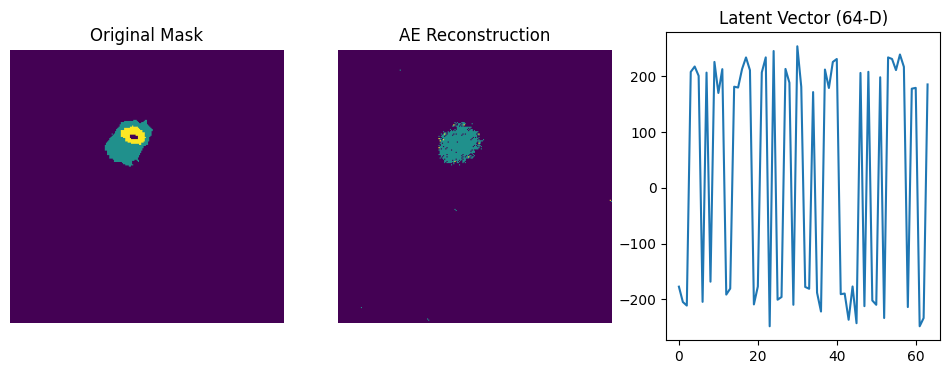

In [ ]:
visualize_ae_reconstruction(10)